<a href="https://colab.research.google.com/github/sharifshars/Deep-learning-Chest-Opacity-Detection/blob/main/Chest_Opacities_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
from tensorflow import keras
from keras import layers
import os
import numpy as np
from keras.applications.vgg19 import preprocess_input


In [5]:
# Path to the images
path_to_images ="/content/drive/MyDrive/Dataset/dataset1/known_images"

In [6]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    path_to_images,
    class_names= ["Normal","Sick"],
    batch_size =32,
    image_size =(395, 488),
    validation_split =0.2,
    subset = "both",
    seed=200
)

Found 715 files belonging to 2 classes.
Using 572 files for training.
Using 143 files for validation.


In [7]:
#instantiating and freesing the VGG19 convolutional base
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top= False,
)

# conv_base.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [8]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg19.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)

    all_features.append(features)
    all_labels.append(labels)

  return np.concatenate(all_features), np.concatenate(all_labels)

In [9]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)

1/1 [==============================] - 28s 28s/step


In [10]:
train_features.shape

(572, 12, 15, 512)

In [11]:
inputs = keras.Input(shape=(12,15, 512))

x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [12]:
model.compile(
    loss ="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [13]:
callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath="chest=opacities-detection-with-with_Vgg19.keras",
        save_best_only=True,
        monitor ="val_loss"
    )
]

In [14]:
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/30
18/18 [==============================] - 4s 217ms/step - loss: 46.2020 - accuracy: 0.8392 - val_loss: 29.9331 - val_accuracy: 0.8531
Epoch 2/30
18/18 [==============================] - 4s 237ms/step - loss: 3.2452 - accuracy: 0.9720 - val_loss: 2.6558 - val_accuracy: 0.9720
Epoch 3/30
18/18 [==============================] - 4s 236ms/step - loss: 0.0581 - accuracy: 0.9965 - val_loss: 1.2594 - val_accuracy: 0.9720
Epoch 4/30
18/18 [==============================] - 4s 205ms/step - loss: 7.0969e-08 - accuracy: 1.0000 - val_loss: 1.2593 - val_accuracy: 0.9720
Epoch 5/30
18/18 [==============================] - 3s 193ms/step - loss: 22.8458 - accuracy: 0.9318 - val_loss: 1.6058 - val_accuracy: 0.9650
Epoch 6/30
18/18 [==============================] - 5s 255ms/step - loss: 0.5640 - accuracy: 0.9930 - val_loss: 3.3306 - val_accuracy: 0.9790
Epoch 7/30
18/18 [==============================] - 4s 195ms/step - loss: 8.0518 - accuracy: 0.9528 - val_loss: 4.0834 - val_accuracy: 0.9650

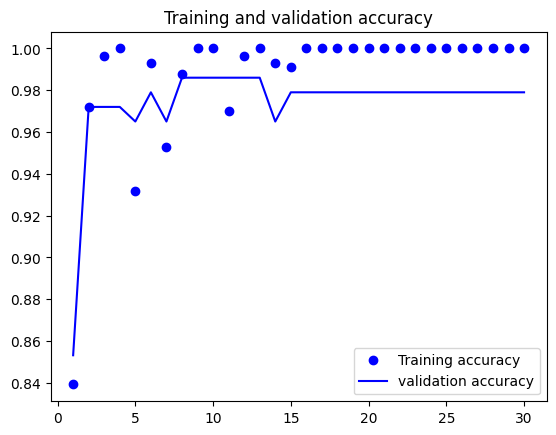

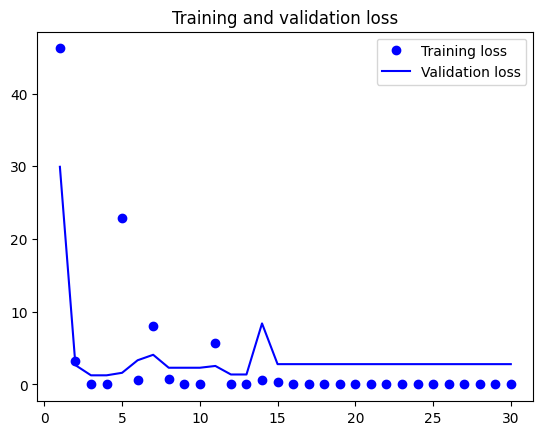

In [15]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss=history.history["loss"]
val_loss =history.history["val_loss"]
epochs = range(1,len(acc)+1)

#Accuracy plots
plt.plot(epochs, acc,"bo", label = "Training accuracy")
plt.plot(epochs,val_acc, "b", label ="validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

#loss plot
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
model = keras.models.load_model("chest=opacities-detection-with-with_Vgg19.keras")
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 15, 512)]     0         
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None, 256)               23593216  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23,593,473
Trainable params: 23,593,473
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Define the directory containing the test images
test_dir = "/content/drive/MyDrive/Dataset/dataset1/unknown_images"

# Get the list of test image file paths
test_image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

In [18]:
# Create an empty array to store predictions and file names
predictions_with_filenames = []

# Loop through each test image, make predictions and store the predicted label
for image_path in test_image_paths:
    # Load the image and resize it to the target size
    img = keras.preprocessing.image.load_img(image_path)

    # Convert the image to a numpy array
    img_array = keras.preprocessing.image.img_to_array(img)

    # prep
    img_array = keras.applications.vgg19.preprocess_input(img_array)

    # Expand the dimensions of the array to create a batch axis
    img_array = np.expand_dims(img_array, 0)

    # Make predictions on the image
    predictions = model.predict(img_array)

    # Convert the predictions to a binary label (0 for Normal, 1 for Sick)
    predicted_label = int(predictions[0] > 0.5)

    # Extract the file name from the image path
    file_name = os.path.basename(image_path)

    # Add the predicted label and file name to the list
    predictions_with_filenames.append((file_name, predicted_label))

ValueError: ignored

In [21]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array =tf.expand_dims(img_array,0)

NameError: ignored

In [ ]:
img_array = keras.application.vgg19.preprocess_input(img_array)

In [ ]:
predictions = model.predict(img_array)
score = float(predictions[0])
score
print(f"This image is {100*(1 - score):.2f}% Normal and {100* score:.2f}% Sick.")